<a href="https://colab.research.google.com/github/ANUPRIYAR/Multilabel_Classification_NLP_LSTM/blob/main/MultiLabelClassification_Consumer_complaints_GloveEmbedding_BidirectionalLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Source: https://catalog.data.gov/dataset/consumer-complaint-database

We will only be using 'Consumer complaint narrative' and 'Product' field for Multi Label Classification model. Other feilds are just used for EDA.

In [2]:
from google.colab import drive

In [3]:
!unzip /content/drive/MyDrive/Deep_learning/complaints.csv.zip

Archive:  /content/drive/MyDrive/Deep_learning/complaints.csv.zip
  inflating: complaints.csv          


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv('/content/complaints.csv')
data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
2,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
3,2019-09-15,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,Pioneer has committed several federal violatio...,NaN,Pioneer Capital Solutions Inc,CA,925XX,NaN,Consent provided,Web,2019-09-15,Closed with explanation,Yes,NaN,3374555
4,2020-11-30,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MA,01605,NaN,NaN,Phone,2020-11-30,Closed with explanation,Yes,NaN,3981945


In [6]:
data.shape

(1869768, 18)

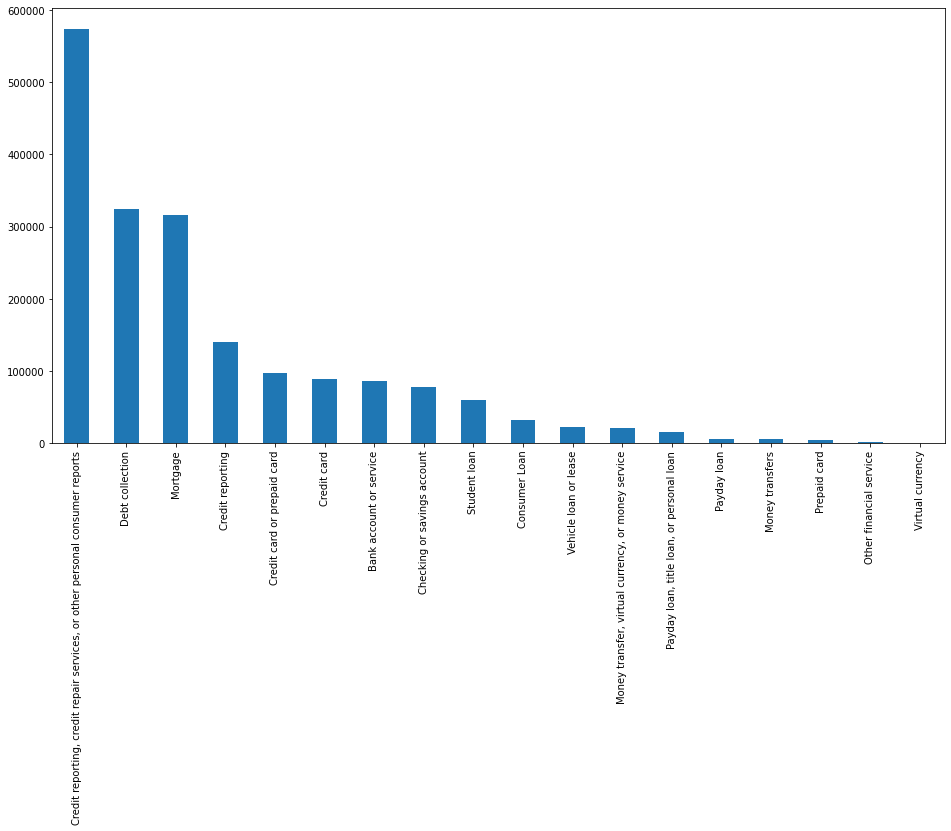

In [7]:
plt.figure(figsize=(16,8))
data['Product'].value_counts().plot(kind='bar')

In [8]:
data['Product'].nunique()

18

If we consider Product field as categorical variable, then there are 18 categories.

In [9]:
data['Sub-product'].value_counts()

Credit reporting                              566753
Checking account                              118233
Other mortgage                                 86635
General-purpose credit card or charge card     72389
Conventional fixed mortgage                    70613
                                               ...  
Credit repair                                    103
Traveler’s/Cashier’s checks                       88
Transit card                                      37
Electronic Benefit Transfer / EBT card            12
Student prepaid card                              12
Name: Sub-product, Length: 76, dtype: int64

In [10]:
data['Sub-product'].nunique()

76

There are 76 unique values for Sub-product , hence better to not consider as categorical variable

# **Reducing the number of categorical Varibales in Product field**

In [11]:
# Reducing the number of Categorical variables

# Merging categories- 'Credit card' and 'Prepaid Card' into 'Credit Card or prepaid Card'
data.loc[data['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
data.loc[data['Product'] == 'Prepaid card', 'Product'] = 'Credit card or prepaid card'


In [12]:
data.loc[data['Product'] == 'Credit card', 'Product'].count(), data.loc[data['Product'] == 'Prepaid card', 'Product'].count()

(0, 0)

In [13]:
# Merging 'Virtual currency' and 'Money transfers' into 'Money transfer, virtual currency, or money service'
data.loc[data['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
data.loc[data['Product'] == 'Money transfers', 'Product'] = 'Money transfer, virtual currency, or money service'

data.loc[data['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'

In [14]:
data.loc[data['Product'] == 'Student loan', 'Product'] = 'Student loan or Consumer loan or Vehicle loan'
data.loc[data['Product'] == 'Consumer Loan', 'Product'] = 'Student loan or Consumer loan or Vehicle loan'
data.loc[data['Product'] == 'Vehicle loan or lease', 'Product'] = 'Student loan or Consumer loan or Vehicle loan'

In [15]:
data.loc[data['Product'] == 'Payday loan, title loan, or personal loan', 'Product'] = 'Student loan or Consumer loan or Vehicle loan or other loans'
data.loc[data['Product'] == 'Student loan or Consumer loan or Vehicle loan', 'Product'] = 'Student loan or Consumer loan or Vehicle loan or other loans'

In [16]:
data['Product'].nunique()

10

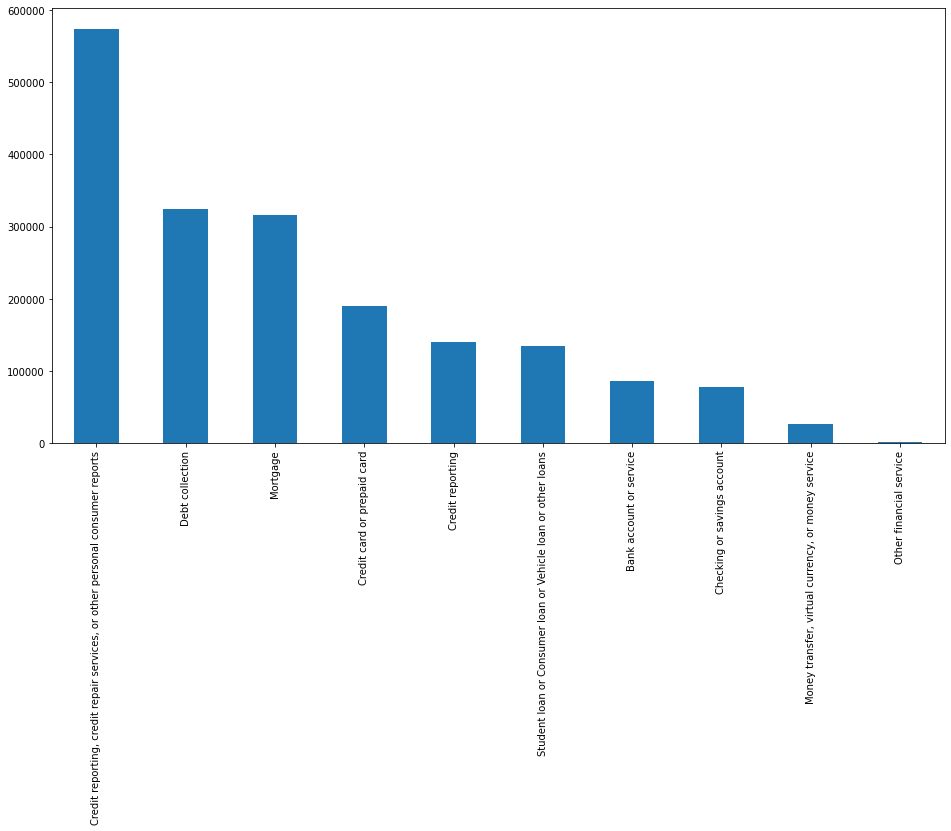

In [17]:
plt.figure(figsize=(16,8))
data['Product'].value_counts().plot(kind='bar')

# **Handling Missing Values**

In [18]:
data['Company public response'].isnull().sum() , data['Consumer disputed?'].isnull().sum() , data['Tags'].isnull().sum() , data['Company public response'].isnull().sum() 

(1096549, 1101294, 1626269, 1096549)

There are a huge set of rows with Null values , hence we can delete the column

In [19]:
data.drop(['Company public response', 'Consumer disputed?', 'Tags', 'Company public response'], axis=1, inplace=True)

In [20]:
data.head(2)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company,State,ZIP code,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,TRANSWORLD SYSTEMS INC,FL,335XX,Consent provided,Web,2019-09-24,Closed with explanation,Yes,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Experian Information Solutions Inc.,PA,15206,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,3379500


**Summary of all the columns with missing values**

In [21]:
#  Get the summary number missing fields in each column
data.isnull().sum()

Date received                         0
Product                               0
Sub-product                      235165
Issue                                 0
Sub-issue                        592093
Consumer complaint narrative    1233643
Company                               0
State                             34968
ZIP code                         182847
Consumer consent provided?       666447
Submitted via                         0
Date sent to company                  0
Company response to consumer          2
Timely response?                      0
Complaint ID                          0
dtype: int64

In [22]:
data.drop(['Sub-product', 'Sub-issue' ,'ZIP code', 'Consumer consent provided?', 'State' ], axis=1, inplace=True)

In [23]:
data.isnull().sum()

Date received                         0
Product                               0
Issue                                 0
Consumer complaint narrative    1233643
Company                               0
Submitted via                         0
Date sent to company                  0
Company response to consumer          2
Timely response?                      0
Complaint ID                          0
dtype: int64

We can see 'Consumer complaint narrative' is having around 12 lakhs missing fields, Since we will be parsing the narrative to find the label of the complaint, missing rows would not make any sense.

In [24]:
# Hence we are dropping all the rows with missing fields
data.dropna(inplace=True)

In [25]:
data.shape

(636124, 10)

In [26]:
data.reset_index()

,index,Date received,Product,Issue,Consumer complaint narrative,Company,Submitted via,Date sent to company,Company response to consumer,Timely response?,Complaint ID
0,0,2019-09-24,Debt collection,Attempts to collect debt not owed,transworld systems inc. \nis trying to collect...,TRANSWORLD SYSTEMS INC,Web,2019-09-24,Closed with explanation,Yes,3384392
1,2,2019-11-08,Debt collection,Communication tactics,"Over the past 2 weeks, I have been receiving e...","Diversified Consultants, Inc.",Web,2019-11-08,Closed with explanation,Yes,3433198
2,3,2019-09-15,Debt collection,Attempts to collect debt not owed,Pioneer has committed several federal violatio...,Pioneer Capital Solutions Inc,Web,2019-09-15,Closed with explanation,Yes,3374555
3,6,2019-07-26,"Credit reporting, credit repair services, or o...",Problem with a credit reporting company's inve...,"Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...",Experian Information Solutions Inc.,Web,2019-07-26,Closed with explanation,Yes,3319331
4,7,2019-07-08,"Credit reporting, credit repair services, or o...",Problem with a credit reporting company's inve...,Hello This complaint is against the three cred...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Web,2019-07-08,Closed with explanation,Yes,3299394
...,...,...,...,...,...,...,...,...,...,...,...
636119,1869763,2016-07-11,Student loan or Consumer loan or Vehicle loan ...,Managing the loan or lease,I was on automatic payment for my car loan. In...,NISSAN MOTOR ACCEPTANCE CORPORATION,Web,2016-07-11,Closed with explanation,Yes,2007463
636120,1869764,2017-01-24,Debt collection,Communication tactics,I recieved a collections call from an unknown ...,"CMRE Financial Services, Inc.",Web,2017-01-24,Closed with explanation,Yes,2308954
636121,1869765,2015-03-26,Mortgage,"Loan servicing, payments, escrow account","On XXXX XXXX, 2015, I contacted XXXX XXXX, who...",Finance of America Mortgage LLC,Web,2015-03-26,Closed with monetary relief,Yes,1303324
636122,1869766,2015-12-12,Mortgage,"Loan servicing, payments, escrow account",I can not get from chase who services my mortg...,JPMORGAN CHASE & CO.,Web,2015-12-12,Closed with explanation,Yes,1694674


In [27]:
data['Submitted via'].value_counts()

Web    636124
Name: Submitted via, dtype: int64

In [28]:
data['Company response to consumer'].value_counts()

Closed with explanation            524944
Closed with non-monetary relief     71986
Closed with monetary relief         31860
Closed                               3741
Untimely response                    3575
In progress                            18
Name: Company response to consumer, dtype: int64

In [29]:
data['Timely response?'].value_counts()

Yes    620840
No      15284
Name: Timely response?, dtype: int64

In [30]:
data['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    224651
Debt collection                                                                 128025
Mortgage                                                                         71758
Credit card or prepaid card                                                      66477
Student loan or Consumer loan or Vehicle loan or other loans                     58230
Credit reporting                                                                 31588
Checking or savings account                                                      26888
Bank account or service                                                          14885
Money transfer, virtual currency, or money service                               13330
Other financial service                                                            292
Name: Product, dtype: int64

In [31]:
data['Company'].value_counts(sort=True, ascending=False).head(20)

EQUIFAX, INC.                             72855
Experian Information Solutions Inc.       69299
TRANSUNION INTERMEDIATE HOLDINGS, INC.    65909
CITIBANK, N.A.                            20177
JPMORGAN CHASE & CO.                      19126
WELLS FARGO & COMPANY                     19078
BANK OF AMERICA, NATIONAL ASSOCIATION     19012
CAPITAL ONE FINANCIAL CORPORATION         17208
Navient Solutions, LLC.                   15340
SYNCHRONY FINANCIAL                       11098
AMERICAN EXPRESS COMPANY                   7201
U.S. BANCORP                               6513
Ocwen Financial Corporation                6175
PORTFOLIO RECOVERY ASSOCIATES INC          6139
NATIONSTAR MORTGAGE                        5879
AES/PHEAA                                  5819
DISCOVER BANK                              5020
ENCORE CAPITAL GROUP INC.                  5006
Alliance Data Card Services                4968
PNC Bank N.A.                              4913
Name: Company, dtype: int64

Text(0, 0.5, 'Number of occurences')

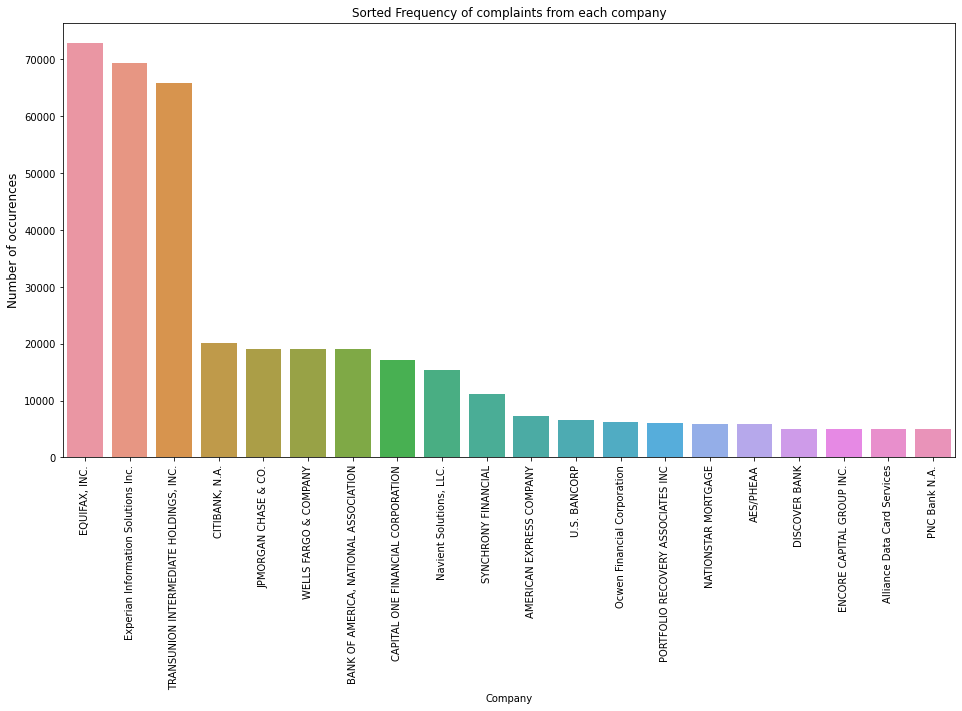

In [32]:
plt.figure(figsize=(16,8))
plt.xticks(rotation='90')
plt.title("Sorted Frequency of complaints from each company")
sns.countplot(data=data, x='Company', order=data['Company'].value_counts(sort=True, ascending=False).head(20).index)
plt.ylabel("Number of occurences", fontsize=12)

**Text processing**

In [33]:
pd.set_option('display.max_colwidth', None)

In [34]:
data['Consumer complaint narrative'][2]

'Over the past 2 weeks, I have been receiving excessive amounts of telephone calls from the company listed in this complaint. The calls occur between XXXX XXXX and XXXX XXXX to my cell and at my job. The company does not have the right to harass me at work and I want this to stop. It is extremely distracting to be told 5 times a day that I have a call from this collection agency while at work.'

In [35]:
import string
import re
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [36]:
 def Clean_Text(text):
   punc = list(string.punctuation)
   punc.remove('.')
   stop_words = stopwords.words('english')
   text = re.sub(r'[\n|\r|\r\n]+', ' ', text)
   text = re.sub(r'[XX]+', '', text)
   text = re.sub(r'[0-9]', '', text)
   text = re.sub(r'//', '', text)
   text = re.sub(r'{$.}', '', text)

   text = [word for word in text.split() if word not in stop_words + punc]
   text = ' '.join(text)
   return text.lower()


In [37]:
data['Consumer complaint narrative'] = data['Consumer complaint narrative'].apply(Clean_Text)

In [38]:
data.reset_index(inplace=True)

In [39]:
data.tail(5)

,index,Date received,Product,Issue,Consumer complaint narrative,Company,Submitted via,Date sent to company,Company response to consumer,Timely response?,Complaint ID
636119,1869763,2016-07-11,Student loan or Consumer loan or Vehicle loan or other loans,Managing the loan or lease,i automatic payment car loan. in fine print supposedly i n't see final payment must made check. i get notice late i stuck negative mark credit report. we never late entire loan. we also moved notice delayed us first baby excuses paid time along small final payment affect credit.,NISSAN MOTOR ACCEPTANCE CORPORATION,Web,2016-07-11,Closed with explanation,Yes,2007463
636120,1869764,2017-01-24,Debt collection,Communication tactics,"i recieved collections call unknown company morning hospital. after hold minutes automated system recording told wait representative, i hung directed website. their website http www.cmrefsi.com/ trusted upon research, seem collection scam. i business i authorized agreed payments company missed payments outstanding accounts.","CMRE Financial Services, Inc.",Web,2017-01-24,Closed with explanation,Yes,2308954
636121,1869765,2015-03-26,Mortgage,"Loan servicing, payments, escrow account","on i contacted branch manager gateway funding, learned i lower mortgage monthly payment approximately {$.} {$.}. i ecstatic i would saved {$.} month. sent via email details of transaction detailing i would pay amount. during escrow process i instructed wire {$.} thought application completed. on contacted stated required pay additional {$.} certain expenses overlooked . i contacted additional expense stated, gateway funding refund {$.} back i send money complete escrow process. i complaining issues i learned mortgage monthly payment {$.} promised instead {$.}, i received refund amount {$.}, promised . when i contacted via telephone monthly payment, stated made mistake. i contacted occasions refund check. i contacted via telephone stated issue check friday application process completed. i contacted stated would authorize refund check. when i last contacted i told i already received it, later verified check issued delivered. it belief taking advantage lack knowledge loan application process informing many years outstanding services promise lower month mortgage payment deceit benefit himself.",Finance of America Mortgage LLC,Web,2015-03-26,Closed with monetary relief,Yes,1303324
636122,1869766,2015-12-12,Mortgage,"Loan servicing, payments, escrow account","i get chase services mortgage, owns original loan docs signatures.",JPMORGAN CHASE & CO.,Web,2015-12-12,Closed with explanation,Yes,1694674
636123,1869767,2016-08-09,Credit card or prepaid card,Transaction issue,"i made payment citi credit card using citi prepaid debit card issued us furnace/air conditioning install. the payment made phone representative citi simplicity i given conformation number complete call. i never say payment post account i called citi back said record payment made . i spoke several departments get answer never took place. i filed dispute citi also called citi rebate card company immediately confirmed payment made received citi credit card date. we email us proof transaction sent citi go forward dispute. i received email showing days later card balance {$.} payment remaining balance card thought dispute resolved. then yesterday i received email stating dispute denied {$.} put back onto balance owed citi . we then called yesterday re-open dispute i re-faxed proof along letter explanation dispute dispute fax number citi also mailed copy presidential office south dakota. then speaking furnace installer citi helping even numerous attempts resolve matter i contacting help case. i sure else payment made, received rebate card citi {$.} balance money received. please help us.","CITIBANK, N.A.",Web,2016-08-09,Closed with non-monetary relief,Yes,2053487


Initializing x and y variables 

In [40]:
x = data['Consumer complaint narrative']
y = data['Product']

In [42]:
y = pd.get_dummies(y,drop_first=True)
y.head(5)

,Checking or savings account,Credit card or prepaid card,Credit reporting,"Credit reporting, credit repair services, or other personal consumer reports",Debt collection,"Money transfer, virtual currency, or money service",Mortgage,Other financial service,Student loan or Consumer loan or Vehicle loan or other loans
0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0


In [52]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

**Convert text into Word Embeddings**

In [53]:
# path  = /content/drive/MyDrive/Deep_learning/Datasets/Nlp_vectors_dataset/glove.6B.50d.txt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence, text

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_test)
print("Found %s unique tokens" %len(tokenizer.word_index))

Found 135780 unique tokens


In [54]:
vocab_size = len(tokenizer.word_index) +1
maxlen=200

In [55]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = sequence.pad_sequences(x_train, padding='post', maxlen=maxlen )
x_test = sequence.pad_sequences(x_test, padding='post', maxlen=maxlen )

In [56]:
vocab_size

135781

In [57]:
x_train.shape, y_train.shape , x_test.shape, y_test.shape

((508899, 200), (508899, 9), (127225, 200), (127225, 9))

**Using GloVe word embeddings to convert text inputs to their numeric counterparts**

Note: When we take glove of 50 dim, then we need to intialize embedding_matrix of dimension 50

In [58]:
from numpy import array
from numpy import asarray
from numpy import zeros

# Initialize a dictionary
embeddings_dictionary = dict()

# Load the glove file
glove_file = open('/content/drive/MyDrive/Deep_learning/Datasets/Nlp_vectors_dataset/glove.6B.50d.txt', encoding='utf8')

for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = asarray(records[1:], dtype='float32')
  embeddings_dictionary[word] = vector_dimensions
glove_file.close()

# Initiliaze Embedding matrix
embedding_matrix = zeros((vocab_size, 50))

for word,index in tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector




# **Create Model**

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(vocab_size, 50, weights=[embedding_matrix],trainable=False))
model.add(Dropout(.3))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(.3))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 50)          6789050   
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               120800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 1809      
Total params: 6,911,659
Trainable params: 122,609
Non-trainable params: 6,789,050
_________________________________________________________________


In [64]:
model.fit(x_train,y_train, validation_split=0.1,batch_size=64, epochs=5)

Epoch 1/5
7157/7157 [==============================] - 157s 22ms/step - loss: 0.8952 - accuracy: 0.6856 - val_loss: 0.7309 - val_accuracy: 0.7440
Epoch 2/5
7157/7157 [==============================] - 154s 22ms/step - loss: 0.8263 - accuracy: 0.7107 - val_loss: 0.7557 - val_accuracy: 0.7387
Epoch 3/5
7157/7157 [==============================] - 153s 21ms/step - loss: 0.8350 - accuracy: 0.7056 - val_loss: 0.7175 - val_accuracy: 0.7548
Epoch 4/5
7157/7157 [==============================] - 153s 21ms/step - loss: 0.8473 - accuracy: 0.7006 - val_loss: 0.7502 - val_accuracy: 0.7450
Epoch 5/5
7157/7157 [==============================] - 154s 21ms/step - loss: 0.8799 - accuracy: 0.6888 - val_loss: 0.8057 - val_accuracy: 0.7232


In [65]:
model.evaluate(x_test,y_test, batch_size=32, verbose=2)

3976/3976 - 36s - loss: 0.7994 - accuracy: 0.7253


[0.7993594408035278, 0.7252584099769592]

In [67]:
from keras.callbacks import EarlyStopping

epochs = 5
batch_size = 64
history = model.fit(x_train, y_train, epochs=epochs, validation_split=0.1, callbacks=[EarlyStopping(monitor ='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
14313/14313 [==============================] - 272s 19ms/step - loss: 0.9132 - accuracy: 0.6763 - val_loss: 0.8359 - val_accuracy: 0.7197
Epoch 2/5
14313/14313 [==============================] - 271s 19ms/step - loss: 0.9324 - accuracy: 0.6687 - val_loss: 0.7999 - val_accuracy: 0.6931
Epoch 3/5
14313/14313 [==============================] - 273s 19ms/step - loss: 0.9500 - accuracy: 0.6610 - val_loss: 0.8401 - val_accuracy: 0.7204
Epoch 4/5
14313/14313 [==============================] - 273s 19ms/step - loss: 0.9727 - accuracy: 0.6534 - val_loss: 0.8521 - val_accuracy: 0.6783
Epoch 5/5
14313/14313 [==============================] - 272s 19ms/step - loss: 0.9871 - accuracy: 0.6486 - val_loss: 0.8602 - val_accuracy: 0.6832


**Plot graph for loss w.r.t epoch value**

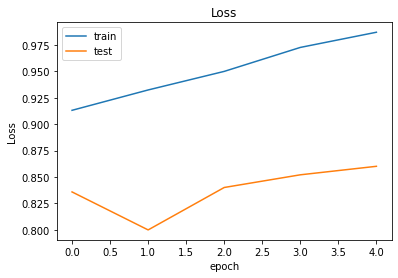

In [72]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

Loss is increasing with increase in epoch

**Plot graph for Accuracy w.r.t epoch value**

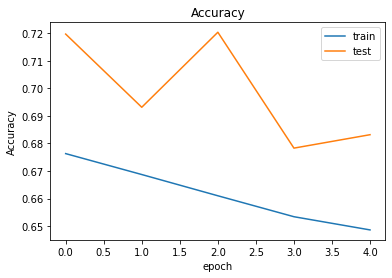

In [73]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Accuracy is decreasing with increase in epoch